# HICO-det

[HICO & HICO-DET Benchmarks for Recognizing Human-Object Interactions in Images](http://www-personal.umich.edu/~ywchao/hico/)

In [1]:
%matplotlib inline
import scipy.io
import pandas
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from IPython.display import display, Markdown

from xib.datasets import HicoDet

hico_dir = Path('../../data/hico_20160224_det_raw')

## Data loading

In [2]:
f = scipy.io.loadmat(hico_dir.joinpath('anno_bbox.mat').as_posix())

In [3]:
actions = []
interactions = []

for interaction in f['list_action'].squeeze():
    interactions.append({
        'action': interaction['vname'].item(),
        'object': interaction['nname'].item()
    })
    actions.append({
        'action': interaction['vname'].item(),
        'ing': interaction['vname_ing'].item(),
        'add_def': interaction['add_def'].tolist(),
        **({
            'id': interaction['synset']['id'].item().item(),
            'wid': interaction['synset']['wid'].item().item(),
            'name': interaction['synset']['name'].item().item(),
            'count': interaction['synset']['count'].item().item(),
            'synonymes': interaction['synset']['syn'].item().item(), 
            'definition': interaction['synset']['def'].item().item(),
            'examples': interaction['synset']['ex'].item().tolist()
        } if interaction['vname'].item() != 'no_interaction' else {})
    })

del interaction

actions = pd.DataFrame(actions).drop_duplicates('action')
interactions = pd.DataFrame(interactions).rename_axis(index='id')

Action types (verbs) and their descriptions.

In [4]:
actions

,action,ing,add_def,id,wid,name,count,synonymes,definition,examples
0,board,boarding,[],1.0,v02018049,board.v.01,6,board get_on,"get on board of (trains, buses, ships, aircraf...",[]
1,direct,directing,[],5.0,v01999798,lead.v.01,131,lead take direct conduct guide,take somebody somewhere,[We lead him to our chief]
2,exit,exiting,[],1.0,v02015598,exit.v.01,72,exit go_out get_out leave,move out of or depart from,[leave the room]
3,fly,flying,[],3.0,v01941093,fly.v.03,6,fly aviate pilot,operate an airplane,[The pilot flew to Cuba]
4,inspect,inspecting,[],1.0,v02165543,inspect.v.01,13,inspect,look over carefully,[Please inspect your father's will carefully]
...,...,...,...,...,...,...,...,...,...,...
551,flush,flushing,[],5.0,v00455529,flush.v.05,0,flush scour purge,"rinse, clean, or empty with a liquid",[flush the wound with antibiotics]
558,brush_with,brushing_with,[],1.0,v01243809,brush.v.01,11,brush,"rub with a brush, or as if with a brush",[Johnson brushed the hairs from his jacket]
562,install,installing,[],1.0,v01569566,install.v.01,37,install instal put_in set_up,set up for use,[install the washer and dryer]
578,lose,losing,[],1.0,v02287789,lose.v.01,123,lose,"fail to keep or to maintain; cease to have, ei...",[She lost her purse when she left it unattende...


Interaction types (verb + object), subject is always "person".

In [5]:
interactions

,action,object
id,,
0,board,airplane
1,direct,airplane
2,exit,airplane
3,fly,airplane
4,inspect,airplane
...,...,...
595,feed,zebra
596,hold,zebra
597,pet,zebra


Objects

In [6]:
for class_idx, class_name in enumerate(interactions.object.drop_duplicates().tolist()):
    print(f'{class_idx:2} {class_name:15}', end='\n' if (class_idx + 1) % 4 == 0 else ' ')

 0 airplane         1 bicycle          2 bird             3 boat           
 4 bottle           5 bus              6 car              7 cat            
 8 chair            9 couch           10 cow             11 dining_table   
12 dog             13 horse           14 motorcycle      15 person         
16 potted_plant    17 sheep           18 train           19 tv             
20 apple           21 backpack        22 banana          23 baseball_bat   
24 baseball_glove  25 bear            26 bed             27 bench          
28 book            29 bowl            30 broccoli        31 cake           
32 carrot          33 cell_phone      34 clock           35 cup            
36 donut           37 elephant        38 fire_hydrant    39 fork           
40 frisbee         41 giraffe         42 hair_drier      43 handbag        
44 hot_dog         45 keyboard        46 kite            47 knife          
48 laptop          49 microwave       50 mouse           51 orange         
52 oven     

Actions

In [7]:
for class_idx, class_name in enumerate(interactions.action.drop_duplicates().tolist()):
    print(f'{class_idx:2} {class_name:15}', end='\n' if (class_idx + 1) % 4 == 0 else ' ')

 0 board            1 direct           2 exit             3 fly            
 4 inspect          5 load             6 ride             7 sit_on         
 8 wash             9 no_interaction  10 carry           11 hold           
12 jump            13 hop_on          14 park            15 push           
16 repair          17 straddle        18 walk            19 chase          
20 feed            21 pet             22 release         23 watch          
24 drive           25 launch          26 row             27 sail           
28 stand_on        29 tie             30 drink_with      31 lick           
32 open            33 pour            34 wave            35 hose           
36 dry             37 hug             38 kiss            39 scratch        
40 lie_on          41 herd            42 lasso           43 milk           
44 clean           45 eat_at          46 sit_at          47 groom          
48 run             49 train           50 race            51 turn           
52 greet    

Image shapes

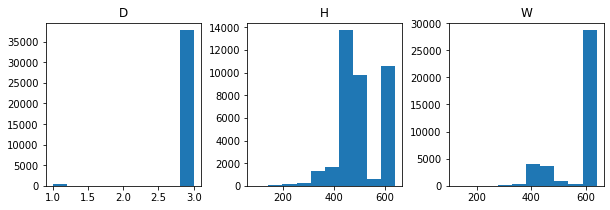

In [8]:
img_info = []
for img in f['bbox_train'].squeeze():
    img_info.append({
        'filename': img['filename'].item(),
        'D': img['size']['depth'].item().item(),
        'H': img['size']['height'].item().item(),
        'W': img['size']['width'].item().item()
    })
del img
img_info = pd.DataFrame(img_info)
img_info.drop(columns='filename').hist(layout=(1,3), figsize=(10, 3), grid=False);

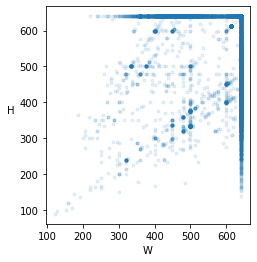

In [9]:
fig, ax = plt.subplots(1, 1)
ax.scatter(img_info.W, img_info.H, marker='.', alpha=.1)
ax.set_xlabel('W')
ax.set_ylabel('H   ', rotation=0)
ax.set_aspect('equal');

Each sample has this structure (from the attached documentation):
```
filename: file names
        size:     image width, hieght, depth
        hoi:      HOI annotations
            id:          action index of list_action
            bboxhuman:   human bounding boxes
            bboxobject:  object bounding boxes
            connection:  instances of HOI (human-object pairs); each row is
                         one instance, represented by a pair of human bbox
                         index and object bbox index
            invis:       1: HOI invisible; bboxhuman/bboxobject/connection
                            will be empty
                         0: HOI visible; bboxhuman/bboxobject/connection
                            will not be empty
```

In [10]:
samples = []

for img in f['bbox_train'].squeeze():
    filename = img['filename'].item()
    
    # All interaction types, e.g. (person, load, truck)
    for interaction in img['hoi'].squeeze(0):
        interaction_id = interaction['id'].item() - 1
        
        # Invisible interaction, no humans or objects visible
        if interaction['invis'].item() == 1:
            samples.append({
                'filename': filename,
                'interaction_id': interaction_id,
                'instance_id': -1,
                'bb_human': None,
                'bb_object': None,
                'visible': False,
            })
            continue
        
        # All humans involved in one or more instances of this interaction
        humans = [
            (human['x1'].item(), human['y1'].item(), human['x2'].item(), human['y2'].item())
            for human in interaction['bboxhuman'].squeeze(0)
        ]
            
        # All objects involved in one or more instances of this interaction
        objects = [
            (object['x1'].item(), object['y1'].item(), object['x2'].item(), object['y2'].item())
            for object in interaction['bboxobject'].squeeze(0)
        ]
        
        # All instances of this interaction type, e.g.
        # (person1, loads, truck1)
        # (person2, loads, truck1)
        # (person3, loads, truck2)
        action_instances = interaction['connection'].shape[0]
        for instance_id, instance in enumerate(interaction['connection']):          
            samples.append({
                'filename': filename,
                'interaction_id': interaction_id,
                'instance_id': instance_id,
                'bb_human': humans[instance[0] - 1],
                'bb_object': objects[instance[1] - 1],
                'visible': True,
            })

samples = pd.DataFrame(samples)

In [11]:
df = pd.merge(
    samples,
    interactions,
    left_on='interaction_id',
    right_index=True
).sort_values('filename')
df.head(10).style.hide_index()

filename,interaction_id,instance_id,bb_human,bb_object,visible,action,object
HICO_train2015_00000001.jpg,152,0,"(208, 33, 427, 300)","(59, 98, 572, 405)",True,race,motorcycle
HICO_train2015_00000001.jpg,155,0,"(209, 26, 444, 317)","(59, 99, 579, 395)",True,straddle,motorcycle
HICO_train2015_00000001.jpg,154,0,"(206, 33, 427, 306)","(61, 100, 571, 401)",True,sit_on,motorcycle
HICO_train2015_00000001.jpg,153,0,"(213, 20, 438, 357)","(77, 115, 583, 396)",True,ride,motorcycle
HICO_train2015_00000002.jpg,223,0,"(262, 1, 638, 138)","(162, 131, 258, 165)",True,no_interaction,banana
HICO_train2015_00000003.jpg,64,0,"(567, 361, 580, 390)","(74, 52, 510, 484)",True,no_interaction,bus
HICO_train2015_00000004.jpg,47,0,"(223, 29, 484, 368)","(269, 89, 363, 122)",True,drink_with,bottle
HICO_train2015_00000004.jpg,48,0,"(221, 30, 485, 372)","(261, 86, 367, 122)",True,hold,bottle
HICO_train2015_00000005.jpg,241,0,"(82, 154, 203, 272)","(1, 176, 313, 422)",True,sit_on,bed
HICO_train2015_00000006.jpg,582,0,"(72, 84, 288, 456)","(8, 16, 372, 334)",True,stand_under,umbrella


Number of boxes per image:
- hard to say because for every interaction type the boxes are redefined, 
  even if a box around the objects involved already exists (see `HICO_train2015_00000001.jpg` above).

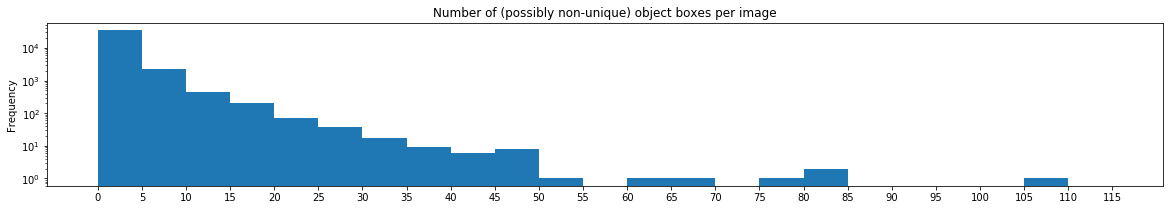

In [12]:
df.groupby('filename').agg({'bb_object': 'nunique'}).bb_object.max()

bins = np.arange(0, df.groupby('filename').agg({'bb_object': 'nunique'}).bb_object.max() + 10, 5)
ax = df.groupby('filename').agg({'bb_object': 'nunique'}).bb_object.plot.hist(logy=True, figsize=(20, 3), bins=bins, align='mid')
ax.set_title('Number of (possibly non-unique) object boxes per image')
ax.set_xticks(bins);

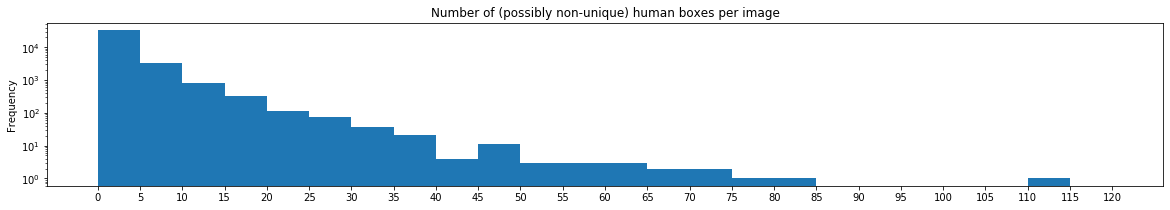

In [13]:
df.groupby('filename').agg({'bb_human': 'nunique'}).bb_human.max()

bins = np.arange(0, df.groupby('filename').agg({'bb_human': 'nunique'}).bb_human.max() + 10, 5)
ax = df.groupby('filename').agg({'bb_human': 'nunique'}).bb_human.plot.hist(logy=True, figsize=(20, 3), bins=bins, align='mid')
ax.set_title('Number of (possibly non-unique) human boxes per image')
ax.set_xticks(bins);

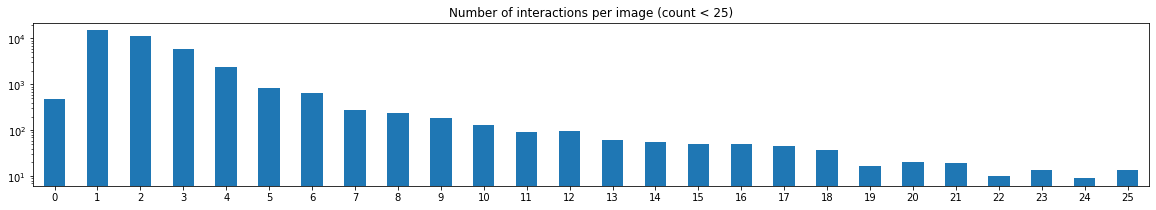

In [14]:
df.groupby('filename').agg({'bb_object': 'nunique'}).bb_object.value_counts().reindex(np.arange(26), fill_value=0) \
  .plot.bar(logy=True, figsize=(20, 3), rot=0) \
  .set_title('Number of interactions per image (count < 25)');

Number of iteractions per image

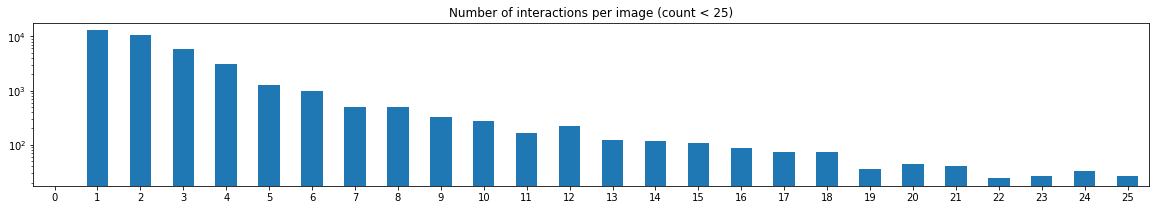

In [15]:
df.groupby('filename').size().value_counts().reindex(np.arange(26), fill_value=0) \
  .plot.bar(logy=True, figsize=(20, 3), rot=0) \
  .set_title('Number of interactions per image (count < 25)');

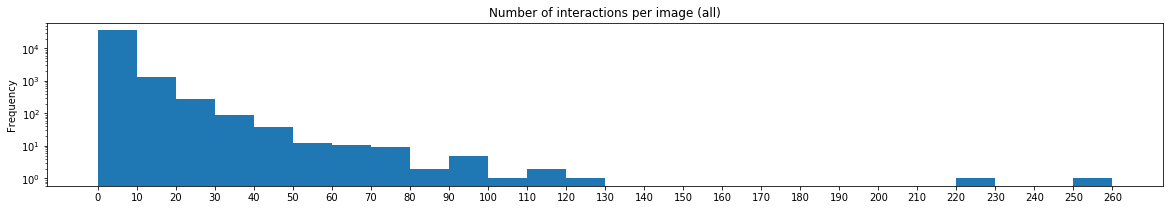

In [16]:
bins = np.arange(0, df.groupby('filename').size().max() + 10, 10)
ax = df.groupby('filename').size().plot.hist(logy=True, figsize=(20, 3), bins=bins, align='mid')
ax.set_title('Number of interactions per image (all)')
ax.set_xticks(bins);

Number of unique action types per image

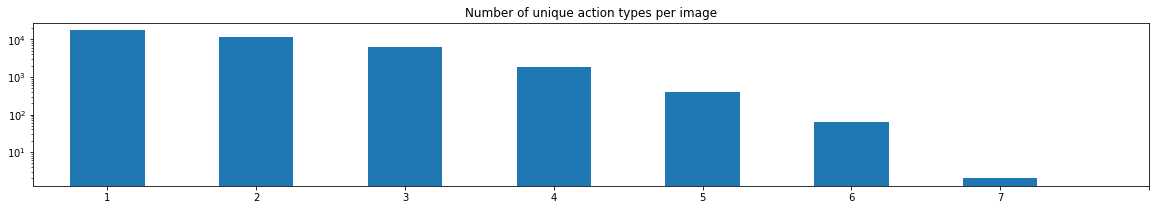

In [17]:
ax = df.groupby('filename').agg({'action': 'nunique'}).action.value_counts().plot.bar(logy=True, figsize=(20, 3), rot=0)
ax.set_title('Number of unique action types per image');
ax.set_xticks(np.arange(df.groupby('filename').agg({'action': 'nunique'}).values.max() + 1));

Number of unique object types per image

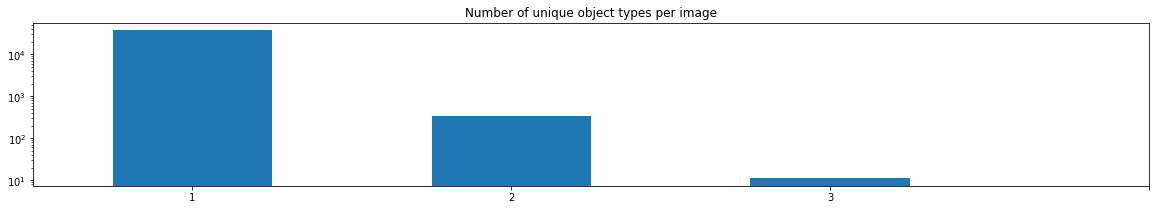

In [18]:
ax = df.groupby('filename').agg({'object': 'nunique'})['object'].value_counts().plot.bar(logy=True, figsize=(20, 3), rot=0)
ax.set_title('Number of unique object types per image');
ax.set_xticks(np.arange(df.groupby('filename').agg({'object': 'nunique'}).values.max() + 1));

Most common actions in the training set

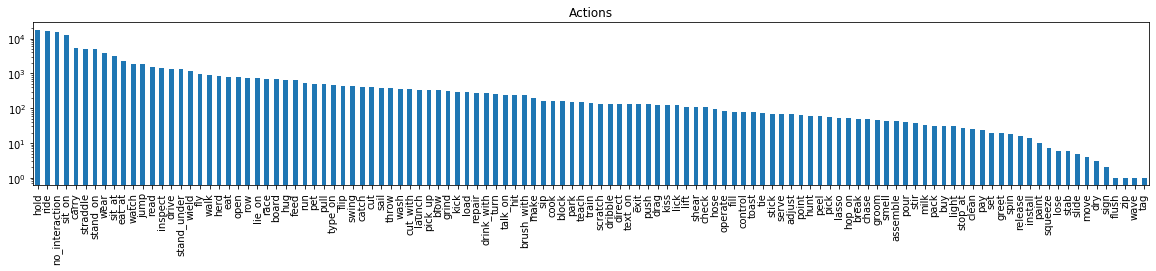

In [19]:
df.action.value_counts().plot.bar(logy=True, figsize=(20, 3)).set_title('Actions');

Most common objects in the training set

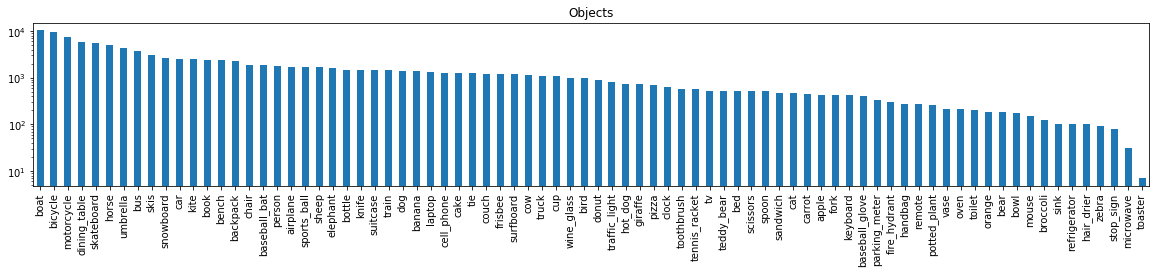

In [20]:
df.object.value_counts().plot.bar(logy=True, figsize=(20, 3)).set_title('Objects');

Most common interactions

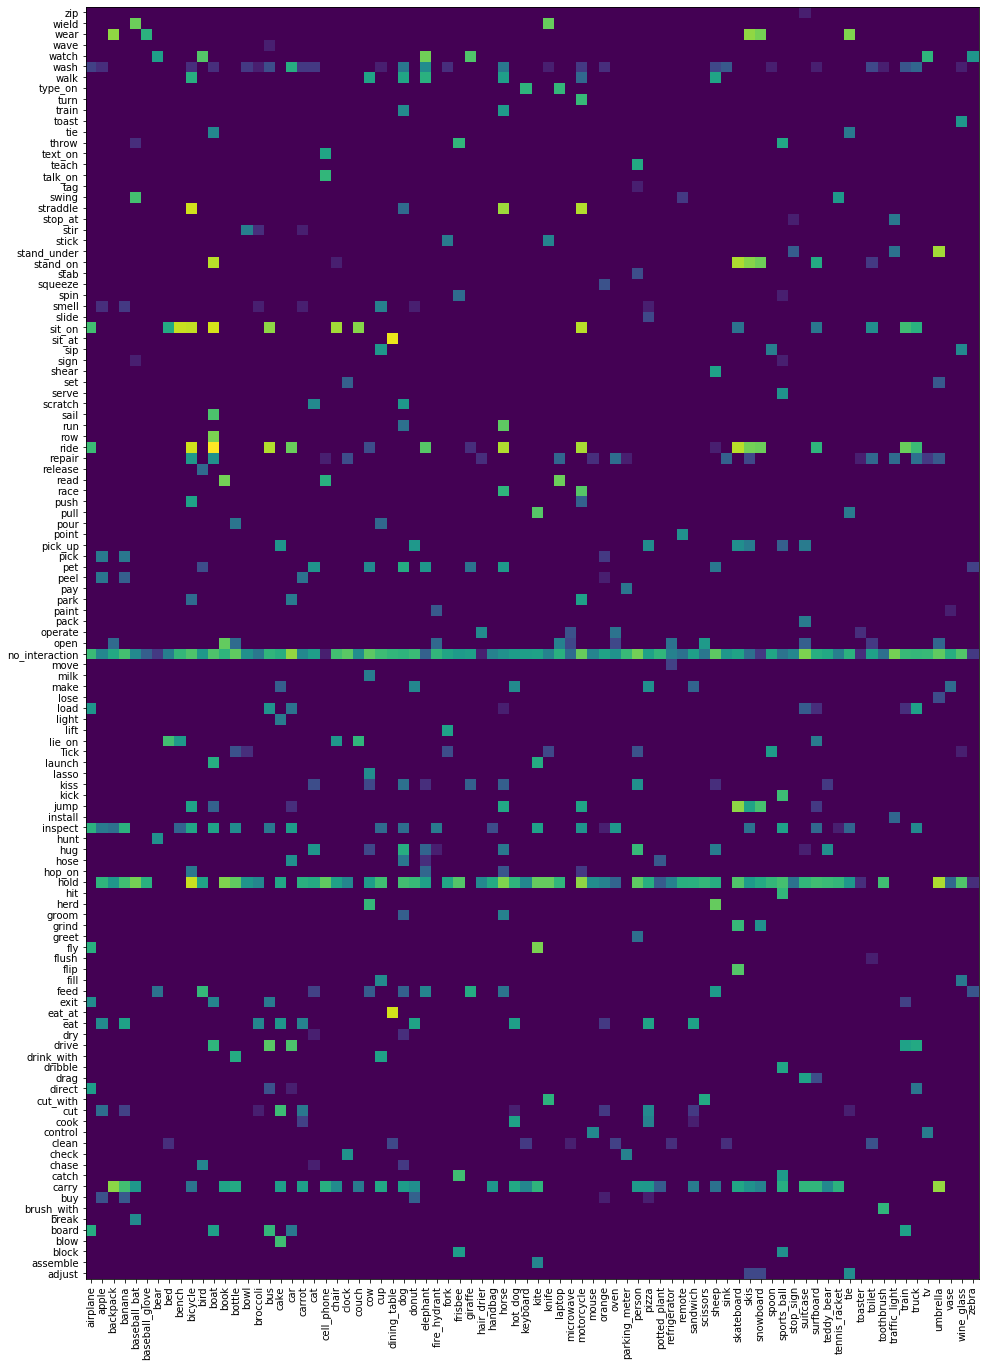

In [21]:
df_freq = df.groupby(['action', 'object']) \
    .interaction_id \
    .count() \
    .unstack('object', fill_value=0)

fig, ax = plt.subplots(1, 1, figsize=(df_freq.shape[1] / 5, df_freq.shape[0] / 5))
ax.pcolormesh(np.arange(df_freq.shape[1] + 1), np.arange(df_freq.shape[0] + 1), np.log(df_freq.values+1))
ax.set_xticks(np.arange(df_freq.shape[1] + 1) + .5)
ax.set_xticklabels(df_freq.columns, rotation=90);
ax.set_yticks(np.arange(df_freq.shape[0] + 1) + .5)
ax.set_yticklabels(df_freq.index, rotation=0)
ax.set_xlim(xmax=ax.get_xlim()[1] - .5)
ax.set_ylim(ymax=ax.get_ylim()[1] - .5);

## Problems

Some problems with the images / annotations

In [22]:
def show_all(filename):
    img = cv2.cvtColor(
            cv2.imread((hico_dir / 'images' / 'train2015' / filename).as_posix()), 
            cv2.COLOR_BGR2RGB
        )
    
    df_img = df.query(f'filename == "{filename}"')
    ncols = min(len(df_img) + 1, 3)
    nrows = int(np.ceil(len(df_img) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(8 * ncols, 8 * nrows), squeeze=False)
    
    ax = axes.flat[0]
    ax.imshow(img)
    ax.set_title(f'{filename} {img.shape[1]} x {img.shape[0]}')
    
    for interaction, ax in zip(df_img.itertuples(), axes.flat[1:]):
        ax.imshow(img)
        ax.set_title(f'{interaction.action} {interaction.object} #{interaction.instance_id}')
        if not interaction.visible:
            continue
        ax.add_artist(plt.Rectangle(
            [interaction.bb_human[0], interaction.bb_human[1]],
            width=interaction.bb_human[2] - interaction.bb_human[0], 
            height=interaction.bb_human[3] - interaction.bb_human[1],
            fill=False,
            linewidth=5,
            color='blue'
        ))
        ax.add_artist(plt.Rectangle(
            [interaction.bb_object[0], interaction.bb_object[1]],
            width=interaction.bb_object[2] - interaction.bb_object[0], 
            height=interaction.bb_object[3] - interaction.bb_object[1],
            fill=False,
            linewidth=5,
            color='red'
        ))
    
    for ax in axes.flat:
        ax.set_axis_off()
    fig.set_facecolor('white')
    save_path = Path(filename).with_suffix('.png')
    fig.savefig(save_path, facecolor='white', bbox_inches='tight')
    plt.close(fig)
    
    display(Markdown(f'### {filename}\n'
                     f'![{filename}]({save_path})'))
    display(df_img.drop(columns='filename').set_index(['interaction_id', 'instance_id']).sort_index())

Same objects but different actions result in different bounding boxes

In [23]:
show_all('HICO_train2015_00000001.jpg')

### HICO_train2015_00000001.jpg
![HICO_train2015_00000001.jpg](HICO_train2015_00000001.png)

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
152,0,"(208, 33, 427, 300)","(59, 98, 572, 405)",True,race,motorcycle
153,0,"(213, 20, 438, 357)","(77, 115, 583, 396)",True,ride,motorcycle
154,0,"(206, 33, 427, 306)","(61, 100, 571, 401)",True,sit_on,motorcycle
155,0,"(209, 26, 444, 317)","(59, 99, 579, 395)",True,straddle,motorcycle


Multiple instances of the same action reuse the bounding boxes instead

In [24]:
show_all('HICO_train2015_00000009.jpg')

### HICO_train2015_00000009.jpg
![HICO_train2015_00000009.jpg](HICO_train2015_00000009.png)

bb_human             bb_object  \
interaction_id instance_id                                               
570            0            (191, 102, 291, 306)  (211, 100, 432, 336)   
               1             (340, 94, 598, 407)  (211, 100, 432, 336)   

                            visible action object  
interaction_id instance_id                         
570            0               True   load  truck  
               1               True   load  truck

No interaction instances

In [25]:
show_all('HICO_train2015_00000002.jpg')

### HICO_train2015_00000002.jpg
![HICO_train2015_00000002.jpg](HICO_train2015_00000002.png)

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
223,0,"(262, 1, 638, 138)","(162, 131, 258, 165)",True,no_interaction,banana


No interaction instances

In [26]:
show_all('HICO_train2015_00000003.jpg')

### HICO_train2015_00000003.jpg
![HICO_train2015_00000003.jpg](HICO_train2015_00000003.png)

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
64,0,"(567, 361, 580, 390)","(74, 52, 510, 484)",True,no_interaction,bus


Debatable human boxes

In [27]:
show_all('HICO_train2015_00000013.jpg')

### HICO_train2015_00000013.jpg
![HICO_train2015_00000013.jpg](HICO_train2015_00000013.png)

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
275,0,"(198, 287, 278, 395)","(88, 206, 248, 310)",True,cut,carrot


Debatable object boxes

In [28]:
show_all('HICO_train2015_00000025.jpg')

### HICO_train2015_00000025.jpg
![HICO_train2015_00000025.jpg](HICO_train2015_00000025.png)

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
432,0,"(273, 11, 446, 392)","(1, 1, 638, 428)",True,open,refrigerator


Invisible interactions

In [29]:
show_all('HICO_train2015_00000014.jpg')

### HICO_train2015_00000014.jpg
![HICO_train2015_00000014.jpg](HICO_train2015_00000014.png)

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
5,-1,None,None,False,load,airplane


Crowds

In [30]:
show_all('HICO_train2015_00000086.jpg')

### HICO_train2015_00000086.jpg
![HICO_train2015_00000086.jpg](HICO_train2015_00000086.png)

bb_human         bb_object  visible  \
interaction_id instance_id                                                    
38             0            (427, 279, 433, 300)  (3, 5, 639, 421)     True   
               1            (259, 254, 267, 276)  (3, 5, 639, 421)     True   
               2            (202, 278, 207, 307)  (3, 5, 639, 421)     True   
               3            (249, 256, 259, 275)  (3, 5, 639, 421)     True   
               4            (231, 259, 246, 273)  (3, 5, 639, 421)     True   
...                                          ...               ...      ...   
42             35            (85, 278, 108, 377)  (1, 3, 637, 422)     True   
               36           (485, 275, 512, 360)  (1, 3, 637, 422)     True   
               37           (563, 273, 592, 384)  (1, 3, 637, 422)     True   
               38           (579, 276, 620, 377)  (1, 3, 637, 422)     True   
               39             (42, 267, 74, 419)  (1, 3, 637, 422)     True   

                              action object  
interaction_id instance_id                   
38             0                ride   boat  
               1                ride   boat  
               2                ride   boat  
               3                ride   boat  
               4                ride   boat  
...                              ...    ...  
42             35           stand_on   boat  
               36           stand_on   boat  
               37           stand_on   boat  
               38           stand_on   boat  
               39           stand_on   boat  

[78 rows x 5 columns]

Smallest image by area

In [31]:
show_all(img_info.iloc[(img_info.H * img_info.W).idxmin()].filename)

### HICO_train2015_00002389.jpg
![HICO_train2015_00002389.jpg](HICO_train2015_00002389.png)

bb_human         bb_object  visible  \
interaction_id instance_id                                                 
366            0              (3, 33, 46, 81)   (11, 7, 34, 58)     True   
               1            (40, 46, 119, 88)  (43, 1, 120, 87)     True   

                             action    object  
interaction_id instance_id                     
366            0            type_on  keyboard  
               1            type_on  keyboard

Most vertically elongated image

In [32]:
show_all(img_info.iloc[(img_info.H / img_info.W).idxmax()].filename)

### HICO_train2015_00011514.jpg
![HICO_train2015_00011514.jpg](HICO_train2015_00011514.png)

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
377,0,"(16, 276, 197, 634)","(20, 10, 168, 333)",True,hold,knife
380,0,"(3, 281, 210, 638)","(33, 3, 125, 318)",True,wield,knife


Most horizontally elongated image

In [33]:
show_all(img_info.iloc[(img_info.H / img_info.W).idxmin()].filename)

### HICO_train2015_00002727.jpg
![HICO_train2015_00002727.jpg](HICO_train2015_00002727.png)

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
329,0,"(617, 55, 640, 101)","(617, 94, 640, 133)",True,no_interaction,fire_hydrant


Just more images

In [34]:
for i in range(50, 60):
    show_all(f'HICO_train2015_000000{i}.jpg')

### HICO_train2015_00000050.jpg
![HICO_train2015_00000050.jpg](HICO_train2015_00000050.png)

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
329,0,"(158, 161, 245, 415)","(223, 299, 292, 416)",True,no_interaction,fire_hydrant


### HICO_train2015_00000051.jpg
![HICO_train2015_00000051.jpg](HICO_train2015_00000051.png)

bb_human             bb_object  \
interaction_id instance_id                                               
225            0            (364, 142, 379, 242)  (368, 235, 393, 391)   
               1             (294, 42, 380, 107)  (368, 235, 393, 391)   
226            0             (281, 39, 384, 411)  (359, 217, 399, 396)   

                            visible action        object  
interaction_id instance_id                                
225            0               True  carry  baseball_bat  
               1               True  carry  baseball_bat  
226            0               True   hold  baseball_bat

### HICO_train2015_00000052.jpg
![HICO_train2015_00000052.jpg](HICO_train2015_00000052.png)

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
226,0,"(2, 50, 264, 427)","(197, 66, 400, 293)",True,hold,baseball_bat
230,0,"(5, 34, 262, 423)","(212, 70, 422, 293)",True,wield,baseball_bat


### HICO_train2015_00000053.jpg
![HICO_train2015_00000053.jpg](HICO_train2015_00000053.png)

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
89,-1,None,None,False,sit_on,chair


### HICO_train2015_00000054.jpg
![HICO_train2015_00000054.jpg](HICO_train2015_00000054.png)

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
462,0,"(18, 18, 417, 639)","(317, 227, 478, 306)",True,no_interaction,skateboard


### HICO_train2015_00000055.jpg
![HICO_train2015_00000055.jpg](HICO_train2015_00000055.png)

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
370,0,"(490, 214, 563, 386)","(90, 94, 141, 146)",True,fly,kite
374,0,"(498, 224, 557, 381)","(552, 90, 637, 225)",True,pull,kite


### HICO_train2015_00000056.jpg
![HICO_train2015_00000056.jpg](HICO_train2015_00000056.png)

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
9,0,"(14, 135, 317, 512)","(153, 16, 478, 138)",True,no_interaction,airplane


### HICO_train2015_00000057.jpg
![HICO_train2015_00000057.jpg](HICO_train2015_00000057.png)

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
75,0,"(594, 112, 630, 152)","(2, 62, 554, 421)",True,no_interaction,car


### HICO_train2015_00000058.jpg
![HICO_train2015_00000058.jpg](HICO_train2015_00000058.png)

,,bb_human,bb_object,visible,action,object
interaction_id,instance_id,,,,,
226,0,"(102, 190, 372, 480)","(258, 138, 354, 314)",True,hold,baseball_bat
230,0,"(104, 193, 370, 479)","(277, 142, 352, 309)",True,wield,baseball_bat


### HICO_train2015_00000059.jpg
![HICO_train2015_00000059.jpg](HICO_train2015_00000059.png)

bb_human            bb_object  \
interaction_id instance_id                                              
154            0             (388, 56, 555, 426)  (51, 213, 637, 422)   
155            0             (148, 94, 292, 267)   (2, 128, 393, 413)   
               1            (395, 101, 557, 423)   (60, 89, 635, 425)   

                            visible    action      object  
interaction_id instance_id                                 
154            0               True    sit_on  motorcycle  
155            0               True  straddle  motorcycle  
               1               True  straddle  motorcycle